In [1]:
import sys
sys.path.insert(0, '../')

import numpy as np
import torch
from torch.autograd import Variable
from FuseNet import FuseNet, CrossEntropy2d
from Solver_FuseNet import Solver_SS
import torch.nn.functional as F

from dataloaders.NYUDv2Loader_HHA import *
from dataloaders.SUNRGBDLoader_HHA import *

%matplotlib inline
from utils.visual_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
def evaluate(model, num_classes, val_loader, data_type):
    # Calculate IoU and Mean accuracies
    print num_classes
    val_confusion = np.zeros((num_classes,3))
    IoU = 0
    mean_acc = 0

    for batch in val_loader:
        val_rgb_inputs  = Variable(batch[0].cuda(gpu_device))
        val_d_inputs    = Variable(batch[1].cuda(gpu_device))
        val_labels      = Variable(batch[2].cuda(gpu_device))
        val_outputs     = model(val_rgb_inputs, val_d_inputs)
        _, val_preds    = torch.max	(val_outputs, 1)

        if (data_type == 'sun' or data_type == 'SUN'):
            val_labels = val_labels - 1     # sun
        elif (data_type == 'nyu' or data_type == 'NYU'):
            val_preds = val_preds + 1       # nyu

        for i in range(num_classes):
            val_labels_mask = val_labels == i
            val_preds_mask = val_preds == i
            TP = np.sum((val_preds == val_labels)[val_labels_mask].data.cpu().numpy())
            #print TP
            val_confusion[i,0] += TP 
            val_confusion[i,1] += np.sum((val_labels==val_labels)[val_labels_mask].data.cpu().numpy()) - TP 
            val_confusion[i,2] += np.sum((val_preds==val_preds)[val_preds_mask].data.cpu().numpy()) - TP 

    for i in range(num_classes):
        TP, FP, FN = val_confusion[i]
        print(TP+FP,FN)
        IoU += TP / (TP + FP + FN)
        mean_acc += TP / (TP + FP)
    IoU /= num_classes
    mean_acc /= num_classes

    print("        Best VALIDATION IoU: %.3f Mean Accuracy: %.3f" % (IoU, mean_acc))

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
data_visualizer = DataVisualizer()

# NYUDv2

In [5]:
gpu_device = 3
num_classes_nyu = 13

In [6]:
v_loader_nyu = NYUDv2Loader_HHA(gpu_device, '/home/dongwonshin/Desktop/Datasets/NYUDv2/', split='val', is_transform=True, img_norm=True, img_size=(240,320))
val_loader_nyu = data.DataLoader(v_loader_nyu, batch_size=4, num_workers=16)

In [31]:
model_nyu = FuseNet(gpu_device, num_classes_nyu, is_HHA=True)
checkpoint = torch.load('../models/nyu_hha/checkpoint25.pth.tar')
model_nyu.load_state_dict(checkpoint['state_dict']) 

In [32]:
sampling_position = 0
for n, sample in enumerate(val_loader_nyu):

    rgb_inputs  = Variable(sample[0].cuda(gpu_device))
    d_inputs    = Variable(sample[1].cuda(gpu_device))
    labels      = Variable(sample[2].cuda(gpu_device))
    val_outputs     = model_nyu(rgb_inputs, d_inputs)
    _, val_preds    = torch.max	(val_outputs, 1)
    
    val_preds = val_preds + 1
    
    if (n > sampling_position) :
        print(np.unique(labels))
        print(np.unique(val_preds))
        break;

[ 0  2  3  5  6  7  8  9 10 12 13]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


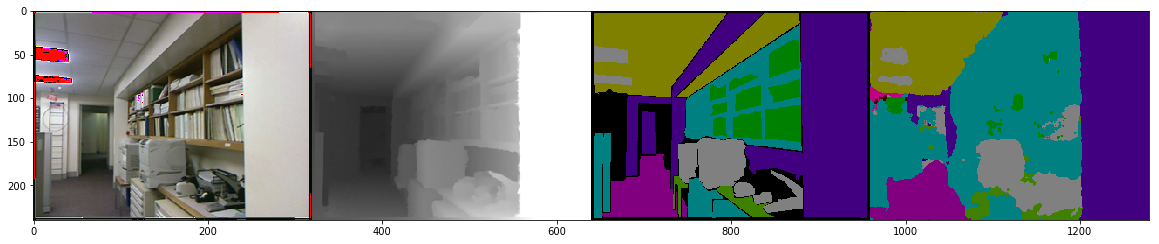

In [34]:
idx = 1
data_visualizer.visualize_all(rgb_inputs[idx], d_inputs[idx], labels[idx], val_preds[idx], 
                              unnormalized_color=True, unnormalized_depth=True)

In [39]:
evaluate(model_nyu, num_classes_nyu, val_loader_nyu, 'NYU')

13
(8590052.0, 0.0)
(2048477.0, 491035.0)
(330180.0, 98214.0)
(645770.0, 326339.0)
(1640338.0, 1117224.0)
(4915685.0, 1373053.0)
(6972920.0, 4419598.0)
(6070799.0, 4311274.0)
(1104096.0, 441643.0)
(1542769.0, 737143.0)
(1778309.0, 998839.0)
(212285.0, 61833.0)
(11829309.0, 4807002.0)
        Best VALIDATION IoU: 0.388 Mean Accuracy: 0.560


# SUNRGBD

In [5]:
gpu_device = 4
num_classes_sun = 38

In [6]:
v_loader_sun = SUNRGBDLoader_HHA(gpu_device, '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/', split='val', is_transform=True, img_norm=True, img_size=(240,320))
val_loader_sun = data.DataLoader(v_loader_sun, batch_size=4, num_workers=16)

In [16]:
model_sun = FuseNet(gpu_device, num_classes_sun, is_HHA=True).cuda()
checkpoint = torch.load('../models/sun_hha/checkpoint25.pth.tar')
model_sun.load_state_dict(checkpoint['state_dict']) 

In [17]:
sampling_position = 14
for n, sample in enumerate(val_loader_sun):

    rgb_inputs  = Variable(sample[0].cuda(gpu_device))
    d_inputs    = Variable(sample[1].cuda(gpu_device))
    labels      = Variable(sample[2].cuda(gpu_device))
    val_outputs     = model_sun(rgb_inputs, d_inputs)
    _, val_preds    = torch.max	(val_outputs, 1)
    
    labels = labels - 1
    
    if (n > sampling_position) :
        print(np.unique(labels))
        print(np.unique(val_preds))
        break;

[ 0  1  2  4  5  6  7  9 10 11 16 21 23 26 35 37]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 18 21 23 24 26 29 30 31
 36]


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f75e35d8f50>> ignored


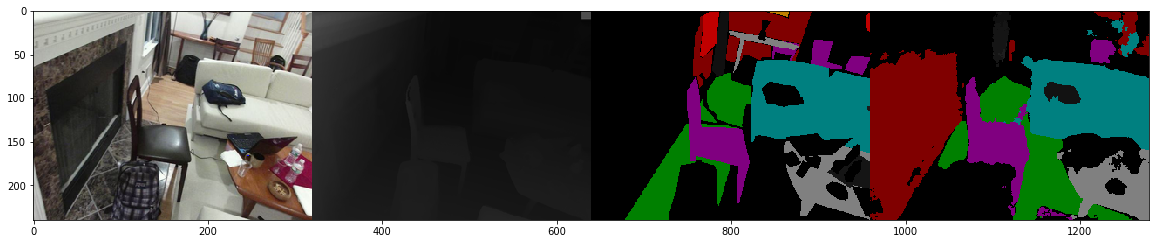

In [20]:
idx = 0
data_visualizer.visualize_all(rgb_inputs[idx], d_inputs[idx], labels[idx], val_preds[idx], 
                              unnormalized_color=True, unnormalized_depth=True)

In [21]:
evaluate(model_sun, num_classes_sun, val_loader_sun, 'SUN')

38
(100380819.0, 58378309.0)
(76950380.0, 23971367.0)
(66248050.0, 13025186.0)
(8192273.0, 3033822.0)
(8423890.0, 2009099.0)
(30644096.0, 13810427.0)
(8244155.0, 3286755.0)
(24590411.0, 8591627.0)
(8046135.0, 3091428.0)
(8101946.0, 3818037.0)
(2579317.0, 368481.0)
(2263473.0, 745191.0)
(2701786.0, 873305.0)
(1273099.0, 399927.0)
(9681808.0, 2171241.0)
(1101587.0, 450334.0)
(3573950.0, 1374730.0)
(1858656.0, 575764.0)
(1627987.0, 540532.0)
(1528022.0, 746840.0)
(190924.0, 2353.0)
(1306164.0, 743551.0)
(3125932.0, 833110.0)
(1578584.0, 402287.0)
(1543665.0, 277816.0)
(552957.0, 89336.0)
(1227810.0, 136388.0)
(579606.0, 132471.0)
(154372.0, 6587.0)
(2292851.0, 387489.0)
(2034632.0, 511093.0)
(330616.0, 185252.0)
(192364.0, 55316.0)
(979421.0, 221181.0)
(1372099.0, 363928.0)
(762264.0, 195739.0)
(602312.0, 46663.0)
(924787.0, 221890.0)
        Best VALIDATION IoU: 0.231 Mean Accuracy: 0.305
